<a href="https://colab.research.google.com/github/wendihexi/EE344_final_project/blob/main/Final_Project_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading packages and data

In [ ]:
# Dataset through Yahoo Finance
!pip install yfinance prophet

# Model Prophet
!pip install prophet

# for a progress bar
!pip install tqdm


In [ ]:
# Importing
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

Dataset

In [ ]:
# getting the NVIDIA stock data starting from january 1st, 1999
nvda = yf.download('NVDA', start = '1999-01-01', auto_adjust = True)

#Show data
nvda.head()
nvda.columns

[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])

In [ ]:
# Shared Varibles
split_date = '2023-01-01'

# Baseline Prophet Model
As basic as I can make it

Preparing the Data for prophet

In [ ]:
# Flatten the MultiIndex columns (('Close','NVDA') → 'Close')
nvda.columns = nvda.columns.get_level_values(0)

# Reset index to turn Date into a column
nvda = nvda.reset_index()

# Prophet expects columns named 'ds' (date) and 'y' (value)
# Select the correct columns and rename them for Prophet
# Prepare Prophet dataframe
prophet_df = nvda[['Date', 'Close']].rename(
    columns={'Date': 'ds', 'Close': 'y'}
)

# Ensure datetime type (usually already correct)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Sanity check
prophet_df.head()


Price,ds,y
0,1999-01-22,0.037605
1,1999-01-25,0.041545
2,1999-01-26,0.038321
3,1999-01-27,0.038202
4,1999-01-28,0.038082


Train and Test Splits

In [ ]:
# Train / Test Split

# Use a time-based split (last ~2 years as test data)

train_df = prophet_df[prophet_df['ds'] < split_date]
test_df  = prophet_df[prophet_df['ds'] >= split_date]

Initilize Model

In [ ]:
# Baseline Prophet Model

# Initialize Prophet with default settings
baseline_model = Prophet()

# Fit the model on training data
baseline_model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting

In [ ]:
# Create future dataframe covering the test period
future = baseline_model.make_future_dataframe(periods=len(test_df))

# Generate forecast
forecast = baseline_model.predict(future)

Plotting

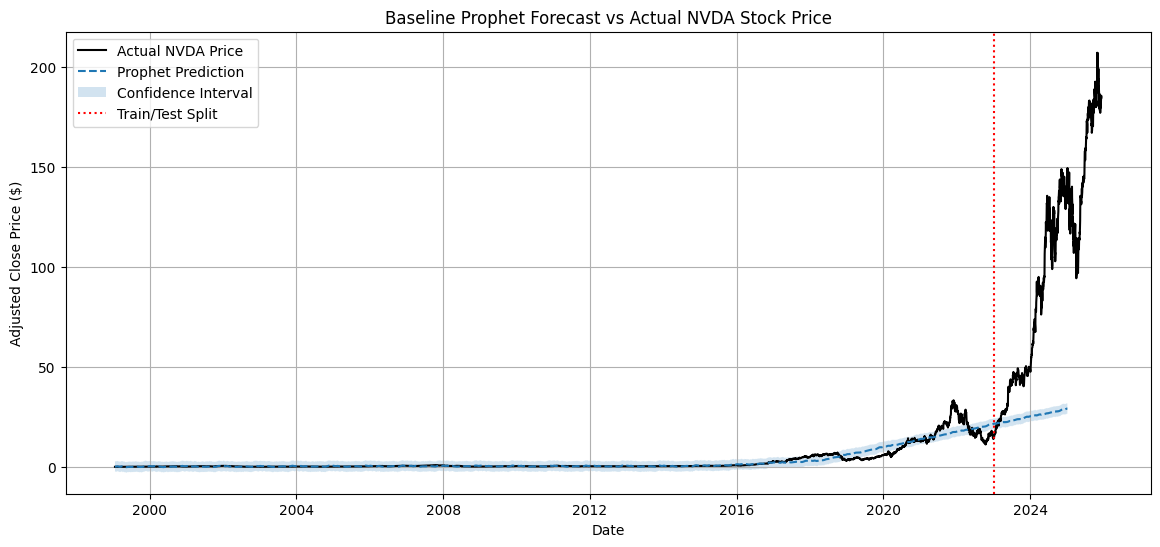

In [ ]:
plt.figure(figsize=(14, 6))

# Plot actual prices
plt.plot(
    prophet_df['ds'],
    prophet_df['y'],
    label='Actual NVDA Price',
    color='black'
)

# Plot Prophet forecast
plt.plot(
    forecast['ds'],
    forecast['yhat'],
    label='Prophet Prediction',
    linestyle='--'
)

# Plot confidence interval
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Mark train/test split
plt.axvline(pd.to_datetime(split_date), color='red', linestyle=':', label='Train/Test Split')

plt.title('Baseline Prophet Forecast vs Actual NVDA Stock Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Align Prophet forecast with test set dates
comparison_df = test_df.merge(
    forecast[['ds', 'yhat']],
    on='ds',
    how='inner'
)

# Extract actual and predicted values
y_true = comparison_df['y']
y_pred = comparison_df['yhat']

# Compute R² score
r2 = r2_score(y_true, y_pred)

print(f"Baseline Prophet R² score: {r2:.4f}")

#Outputted R2 score = -1.2198, this is a VERY poor score,

Baseline Prophet R² score: -1.2227


The baseline Prophet model produced a negative out-of-sample R² score, indicating that it underperformed a naive mean predictor when forecasting NVDA’s daily adjusted closing prices. This result highlights the difficulty of predicting equity price levels in the presence of regime shifts and news-driven volatility. Prophet’s trend-smoothing assumptions limit its ability to extrapolate rapid structural changes, particularly during periods of explosive growth.

# Slightly ImprovedProphet Model - Log-transformed Price and Flexible Trend<br>
Log-transform prices help stablize variance which should improve the R^2 score <br>
Flexible trends should help the model adapt better the changes in NVIDIA stock


In [ ]:

# Log-Transform the Target
prophet_log_df = prophet_df.copy()

# Log-transform the adjusted close price
prophet_log_df['y'] = np.log(prophet_log_df['y'])

#Train/Test Split
train_log_df = prophet_log_df[prophet_log_df['ds'] < split_date]
test_log_df  = prophet_log_df[prophet_log_df['ds'] >= split_date]

# Implement
improved_model = Prophet(
    #This controls how flexible the trend is (0.01 is very small and thus smooth behavior, the default is 0.05)
    changepoint_prior_scale=0.25  # more flexible trend than baseline
)

# Fit model
improved_model.fit(train_log_df)

# forecast
# Create future dataframe
future_log = improved_model.make_future_dataframe(periods=len(test_log_df))

# Generate forecast
forecast_log = improved_model.predict(future_log)

# Inverse Log Transform
#Convert prediction back to price scale
forecast_log['yhat'] = np.exp(forecast_log['yhat'])
forecast_log['yhat_lower'] = np.exp(forecast_log['yhat_lower'])
forecast_log['yhat_upper'] = np.exp(forecast_log['yhat_upper'])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


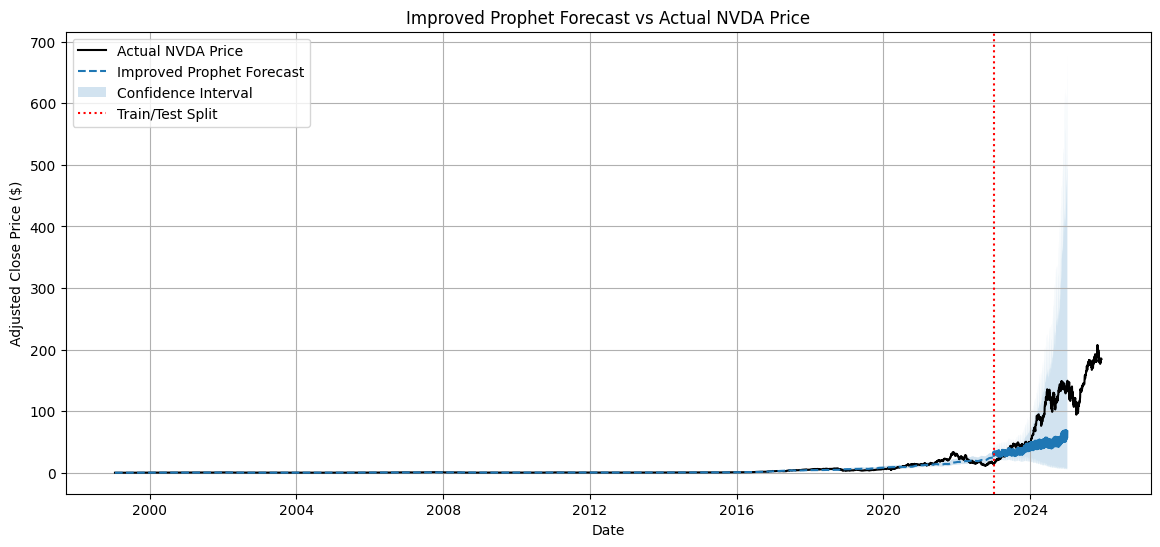

In [ ]:
# Plot: Full History

plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_df['ds'],
    prophet_df['y'],
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast
plt.plot(
    forecast_log['ds'],
    forecast_log['yhat'],
    linestyle='--',
    label='Improved Prophet Forecast'
)

# Uncertainty interval
plt.fill_between(
    forecast_log['ds'],
    forecast_log['yhat_lower'],
    forecast_log['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train / Test split
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Improved Prophet Forecast vs Actual NVDA Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Align predictions with test set
comparison_log = test_df.merge(
    forecast_log[['ds', 'yhat']],
    on='ds',
    how='inner'
)

# Compute R²
r2_log = r2_score(comparison_log['y'], comparison_log['yhat'])

print(f"Improved Prophet (Log + Flexible Trend) R²: {r2_log:.4f}")

# Improved Prophet (Log + Flexible Trend)
# When Changepoint = 0.15 -> R²: -0.5152, Its still bad, but it is in fact slightly better
# When Changepoint = 0.25 -> R²: -0.4935,
# When Changepoint = 0.50 -> R²: -0.4789,
# When Changepoint = 1.00 -> R²: -0.4727,

Improved Prophet (Log + Flexible Trend) R²: -0.4955


The changepoint prior scale was varied to evaluate the effect of increased trend flexibility on out-of-sample performance. As the changepoint prior scale increased from 0.15 to 1.00, the R² score improved monotonically from −0.5152 to −0.4727. This indicates that allowing the model to respond more aggressively to structural changes in the trend partially mitigates Prophet’s tendency to underfit NVDA’s rapid growth during the test period.

However, despite the improvement, all configurations yielded negative R² scores, indicating that even the most flexible models still underperformed a naive mean predictor. This outcome reflects the inherent difficulty of forecasting daily stock price levels, particularly for an asset such as NVDA that experienced abrupt regime shifts driven by external information (e.g., earnings reports and AI-related news) that Prophet does not explicitly model.

Although the highest R² was achieved at changepoint_prior_scale = 1.00, this value introduces a substantial risk of overfitting and produces highly unstable trend extrapolations. As a result, it is not appropriate as a foundation for more complex models.

Based on the changepoint sensitivity analysis, a changepoint prior scale of 0.25 was selected as the foundation for subsequent models. This value improved forecast performance relative to the baseline while maintaining reasonable trend stability and limiting overfitting.

# Enhanced Prophet (Log + Flexible Trend + Custom Seasonality)
Keeps log transform (stabilizes variance)

Keeps changepoint flexibility

Adds custom monthly seasonality

Explicitly enables weekly & yearly seasonality

In [ ]:
# Log-Transform the Target
prophet_season_df = prophet_df.copy()

# Log-transform the adjusted close price
prophet_season_df['y'] = np.log(prophet_season_df['y'])

#Train/Test Split
train_season_df = prophet_season_df[prophet_season_df['ds'] < split_date]
test_season_df  = prophet_season_df[prophet_season_df['ds'] >= split_date]

#model
complex_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.25,   # chosen from previous tuning
    changepoint_range=0.8
)

# Add custom monthly seasonality
complex_model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=5
)

#train
complex_model.fit(train_season_df[['ds', 'y']])


# forecast
future = complex_model.make_future_dataframe(periods=len(test_season_df), freq='D')
forecast = complex_model.predict(future)

# Align forecast with test dates
forecast_test = forecast[forecast['ds'].isin(test_season_df['ds'])].copy()

# Convert predictions back from log scale by applying np.exp to relevant columns in forecast_test
forecast_test['yhat'] = np.exp(forecast_test['yhat'])
forecast_test['yhat_lower'] = np.exp(forecast_test['yhat_lower'])
forecast_test['yhat_upper'] = np.exp(forecast_test['yhat_upper'])

# y_true is still needed for R2 score, keep it as numpy array of original values
y_true = test_season_df['y'].values


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


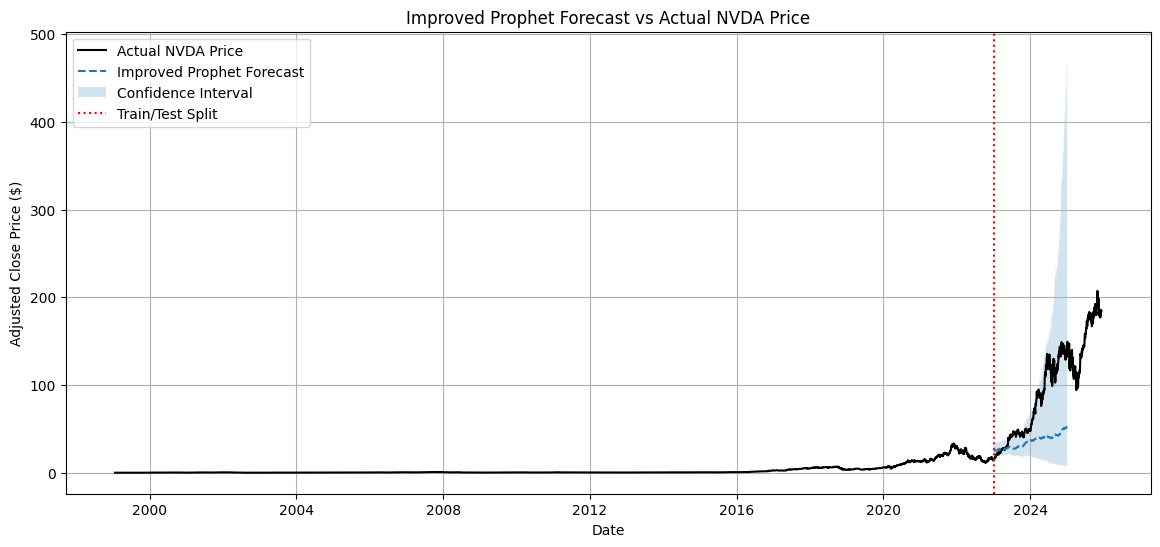

In [ ]:

# Plot: Full History

plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_df['ds'],
    prophet_df['y'],
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast (use forecast_test directly after transformation)
plt.plot(
    forecast_test['ds'],
    forecast_test['yhat'],
    linestyle='--',                  # This is the line that was causing the error
    label='Improved Prophet Forecast'
)

# Uncertainty interval (use forecast_test directly after transformation)
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train / Test split
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Improved Prophet Forecast vs Actual NVDA Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Align predictions with test set
comparison_log = test_df.merge(
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='inner'
)

# Compute R²
r2_log = r2_score(comparison_log['y'], comparison_log['yhat'])

print(f"Improved Prophet (Log + Flexible Trend) R²: {r2_log:.4f}")

# Improved Prophet (Log + Flexible Trend) R²: -0.4943,
# this is slightly worse than the previous model at R²: -0.4935,

Improved Prophet (Log + Flexible Trend) R²: -0.4946


Adding seasonality hasn't made a significant difference

# Rolling Forecast Implementation
Forecast one day ahead at each step. Add the actual point to the training set

In [ ]:
# Data Preparation
# ------------------------
prophet_season_df = prophet_df.copy()

# Log-transform the adjusted close price
prophet_season_df['y'] = np.log(prophet_season_df['y'])

# Train/Test Split
split_date = '2023-01-01'
train_season_df = prophet_season_df[prophet_season_df['ds'] < split_date].copy()
test_season_df  = prophet_season_df[prophet_season_df['ds'] >= split_date].copy()

# Rolling Forecast

from tqdm.notebook import tqdm

preds = []

# Wrap loop with tqdm for progress
for i in tqdm(range(len(test_season_df)), desc="Rolling Forecast Progress"):
    # Fit Prophet on current training window
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25,
        changepoint_range=0.8
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(train_df)

    # Forecast next day only
    future = model.make_future_dataframe(periods=1, freq='D')
    forecast = model.predict(future)

    # Transform prediction back from log
    yhat = np.exp(forecast['yhat'].iloc[-1])
    yhat_lower = np.exp(forecast['yhat_lower'].iloc[-1])
    yhat_upper = np.exp(forecast['yhat_upper'].iloc[-1])

    preds.append({
        'ds': test_season_df['ds'].iloc[i],
        'yhat': yhat,
        'yhat_lower': yhat_lower,
        'yhat_upper': yhat_upper
    })

    # Add actual observation to training for next step
    next_point = pd.DataFrame({
        'ds': [test_season_df['ds'].iloc[i]],
        'y': [test_season_df['y'].iloc[i]]
    })
    train_df = pd.concat([train_df, next_point], ignore_index=True)

# Convert predictions to DataFrame
forecast_test = pd.DataFrame(preds)

Rolling Forecast Progress:   0%|          | 0/736 [00:00<?, ?it/s]

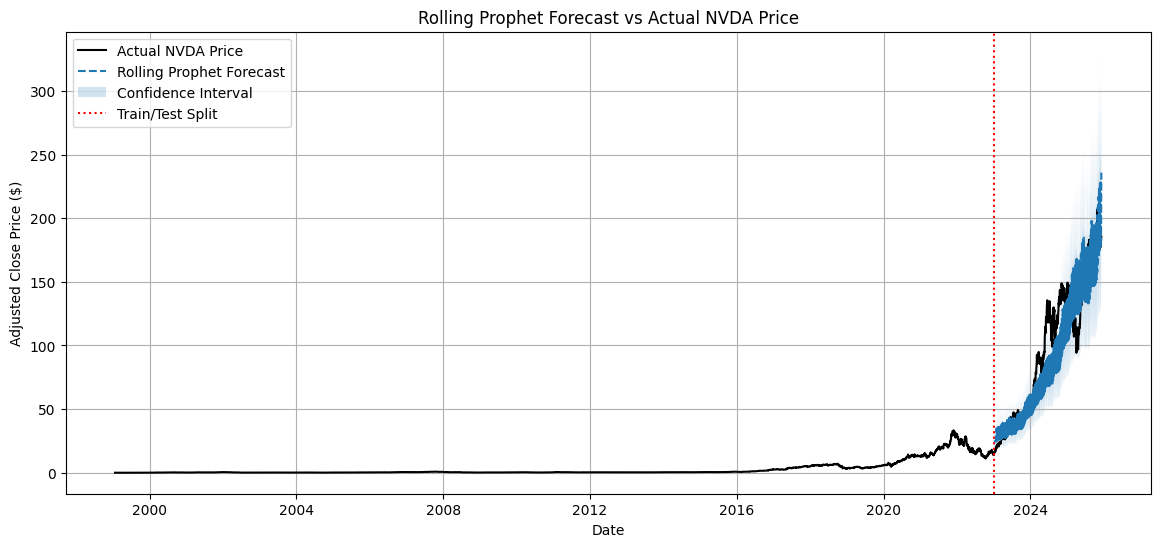

In [ ]:
# Plot: Full History
# ------------------------
plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_df['ds'],
    prophet_df['y'],
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast (rolling)
plt.plot(
    forecast_test['ds'],
    forecast_test['yhat'],
    linestyle='--',
    label='Rolling Prophet Forecast'
)

# Uncertainty interval
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train / Test split
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Rolling Prophet Forecast vs Actual NVDA Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compare predicted vs actual (back-transformed)
y_true = np.exp(test_season_df['y'].values)
y_pred = forecast_test['yhat'].values

r2_rolling = r2_score(y_true, y_pred)
print(f"Rolling Forecast R²: {r2_rolling:.4f}")

Rolling Forecast R²: 0.7419


# Adding Regressors
SPY -> helps capture general market trends <br>
Volume -> High trading volume may indicate price pressure <br>
Maybe add VIX -> Volatility Index helps capture market uncertainty <br>

In [ ]:
# Market index (SPY) as external regressor
spy = yf.download('SPY', start='1999-01-01')

/tmp/ipython-input-3030279874.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='1999-01-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# sanity check
print(prophet_regressors[['y','SPY','Volume']].describe())


# ------------------------
# Prepare DataFrame for Prophet
# ------------------------
prophet_regressors = prophet_df.copy()

# Merge SPY close price
spy_df = spy.reset_index()[['Date', 'Close']]
spy_df.columns = ['ds', 'SPY']
prophet_regressors = prophet_regressors.merge(spy_df, on='ds', how='left')

# Merge NVDA Volume (from original nvda dataframe)
nvda_volume_df = nvda.reset_index()[['Date', 'Volume']]
nvda_volume_df.columns = ['ds', 'Volume']
prophet_regressors = prophet_regressors.merge(nvda_volume_df, on='ds', how='left')


# Log-transform target
prophet_regressors['y'] = np.log(prophet_regressors['y'])

# Train/Test split
train_df = prophet_regressors[prophet_regressors['ds'] < split_date].copy()
test_df  = prophet_regressors[prophet_regressors['ds'] >= split_date].copy()

# ------------------------
# Rolling Forecast with External Regressors
# ------------------------
preds = []
train_temp = train_df[['ds','y','SPY','Volume']].copy()

for i in tqdm(range(len(test_df)), desc="Rolling Forecast Progress"):
    # Fit Prophet model
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25,
        changepoint_range=0.8
    )

    # Add monthly seasonality
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # Add regressors
    model.add_regressor('SPY')
    model.add_regressor('Volume')

    # Fit model on current training window
    model.fit(train_temp)

    # Forecast next day
    future = test_df[['ds','SPY','Volume']].iloc[[i]].copy()
    forecast = model.predict(future)

    # Transform prediction back from log
    yhat = np.exp(forecast['yhat'].iloc[0])
    yhat_lower = np.exp(forecast['yhat_lower'].iloc[0])
    yhat_upper = np.exp(forecast['yhat_upper'].iloc[0])

    preds.append({
        'ds': test_df['ds'].iloc[i],
        'yhat': yhat,
        'yhat_lower': yhat_lower,
        'yhat_upper': yhat_upper
    })

    # Add actual observation to training for next iteration
    next_row = pd.DataFrame({
        'ds': [test_df['ds'].iloc[i]],
        'y': [test_df['y'].iloc[i]],
        'SPY': [test_df['SPY'].iloc[i]],
        'Volume': [test_df['Volume'].iloc[i]]
    })
    train_temp = pd.concat([train_temp, next_row], ignore_index=True)

# Convert predictions to DataFrame
forecast_test = pd.DataFrame(preds)

Rolling Forecast Progress:   0%|          | 0/736 [00:00<?, ?it/s]

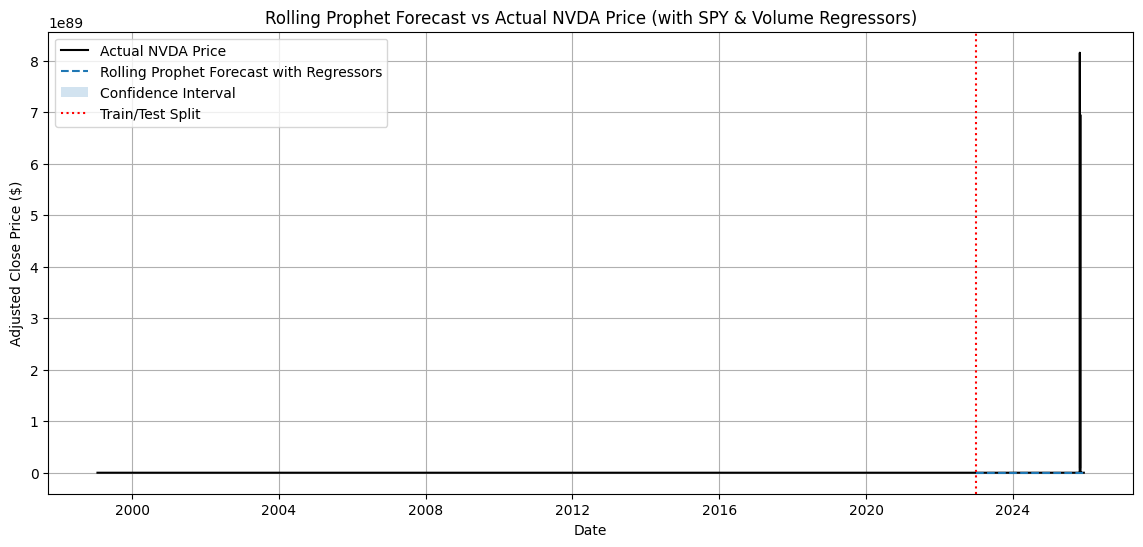

In [ ]:
# Plot: Full History
# ------------------------
plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_df['ds'],
    np.exp(prophet_df['y']),
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast (rolling with regressors)
plt.plot(
    forecast_test['ds'],
    forecast_test['yhat'],
    linestyle='--',
    label='Rolling Prophet Forecast with Regressors'
)

# Uncertainty interval
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train / Test split
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Rolling Prophet Forecast vs Actual NVDA Price (with SPY & Volume Regressors)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute R²
# ------------------------
y_true = np.exp(test_df['y'].values)
y_pred = forecast_test['yhat'].values
r2_score_value = r2_score(y_true, y_pred)
print(f"Rolling Forecast with Regressors R²: {r2_score_value:.4f}")

Rolling Forecast with Regressors R²: 0.5495


In [ ]:
# attempt 2

# prepare base prophet dataframe
# NVDA adjusted price (Close is already adjusted with auto_adjust=True)
prophet_df = nvda.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']

# add the external regressors
# SPY close price
spy_df = spy.reset_index()[['Date', 'Close']]
spy_df.columns = ['ds', 'SPY']

# NVDA trading volume
volume_df = nvda.reset_index()[['Date', 'Volume']]
volume_df.columns = ['ds', 'Volume']

# Merge regressors
prophet_regressors = prophet_df.merge(spy_df, on='ds', how='left')
prophet_regressors = prophet_regressors.merge(volume_df, on='ds', how='left')

# Forward fill missing values
prophet_regressors[['SPY','Volume']] = (
    prophet_regressors[['SPY','Volume']]
    .fillna(method='ffill')
)

# log transform
prophet_regressors['y'] = np.log(prophet_regressors['y'])
prophet_regressors['SPY'] = np.log(prophet_regressors['SPY'])
prophet_regressors['Volume'] = np.log(prophet_regressors['Volume'])

# train/test split
split_date = '2018-01-01'

train_df = prophet_regressors[prophet_regressors['ds'] < split_date].copy()
test_df  = prophet_regressors[prophet_regressors['ds'] >= split_date].copy()


# Rolling forecast
preds = []
train_temp = train_df[['ds','y','SPY','Volume']].copy()

for i in tqdm(range(len(test_df)), desc="Rolling Forecast Progress"):

    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25,
        changepoint_range=0.8
    )

    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )

    model.add_regressor('SPY')
    model.add_regressor('Volume')

    model.fit(train_temp)

    # Predict next day
    future = test_df[['ds','SPY','Volume']].iloc[[i]]
    forecast = model.predict(future)

    # Back-transform
    preds.append({
        'ds': test_df.iloc[i]['ds'],
        'yhat': np.exp(forecast['yhat'].iloc[0]),
        'yhat_lower': np.exp(forecast['yhat_lower'].iloc[0]),
        'yhat_upper': np.exp(forecast['yhat_upper'].iloc[0])
    })

    # Append actual observation
    new_row = test_df[['ds','y','SPY','Volume']].iloc[[i]]
    train_temp = pd.concat([train_temp, new_row], ignore_index=True)


# convert predictions
forecast_test = pd.DataFrame(preds)



/tmp/ipython-input-3653527058.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


Rolling Forecast Progress:   0%|          | 0/1996 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_regressors['ds'],
    np.exp(prophet_regressors['y']),
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast
plt.plot(
    forecast_test['ds'],
    forecast_test['yhat'],
    linestyle='--',
    label='Rolling Prophet Forecast'
)

# Confidence interval
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train/test split line
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Rolling Prophet Forecast vs Actual NVDA Price (SPY + Volume)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_true = np.exp(test_df['y'].values)
y_pred = forecast_test['yhat'].values

r2 = r2_score(y_true, y_pred)
print(f"Rolling Prophet w/ Regressors R²: {r2:.4f}")


# Adding VIX

In [ ]:
# Market index (SPY)
spy = yf.download('SPY', start='1999-01-01')

# Volatility index (VIX)
vix = yf.download('^VIX', start='1999-01-01')

In [ ]:
# prepare base prophet data frame

# NVDA adjusted clos=
prophet_df = nvda.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']

# Add external regressors
# SPY close price
spy_df = spy.reset_index()[['Date', 'Close']]
spy_df.columns = ['ds', 'SPY']

# NVDA trading volume
volume_df = nvda.reset_index()[['Date', 'Volume']]
volume_df.columns = ['ds', 'Volume']

# VIX close value
vix_df = vix.reset_index()[['Date', 'Close']]
vix_df.columns = ['ds', 'VIX']

# Merge all regressors
prophet_regressors = prophet_df.merge(spy_df, on='ds', how='left')
prophet_regressors = prophet_regressors.merge(volume_df, on='ds', how='left')
prophet_regressors = prophet_regressors.merge(vix_df, on='ds', how='left')

# Forward-fill missing values
prophet_regressors[['SPY','Volume','VIX']] = (
    prophet_regressors[['SPY','Volume','VIX']]
    .fillna(method='ffill')
)


# Log transform -> makes sure all inputs are on the same scale
prophet_regressors['y'] = np.log(prophet_regressors['y'])
prophet_regressors['SPY'] = np.log(prophet_regressors['SPY'])
prophet_regressors['Volume'] = np.log(prophet_regressors['Volume'])
prophet_regressors['VIX'] = np.log(prophet_regressors['VIX'])


# train/test splits
split_date = '2018-01-01'

train_df = prophet_regressors[prophet_regressors['ds'] < split_date].copy()
test_df  = prophet_regressors[prophet_regressors['ds'] >= split_date].copy()

#Rolling Forcast
preds = []
train_temp = train_df[['ds','y','SPY','Volume','VIX']].copy()

for i in tqdm(range(len(test_df)), desc="Rolling Forecast Progress"):

    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25,
        changepoint_range=0.8
    )

    # Monthly seasonality
    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )

    # Add regressors
    model.add_regressor('SPY')
    model.add_regressor('Volume')
    model.add_regressor('VIX')

    model.fit(train_temp)

    # Forecast next day
    future = test_df[['ds','SPY','Volume','VIX']].iloc[[i]]
    forecast = model.predict(future)

    # Back-transform predictions
    preds.append({
        'ds': test_df.iloc[i]['ds'],
        'yhat': np.exp(forecast['yhat'].iloc[0]),
        'yhat_lower': np.exp(forecast['yhat_lower'].iloc[0]),
        'yhat_upper': np.exp(forecast['yhat_upper'].iloc[0])
    })

    # Add observed point to training window
    new_row = test_df[['ds','y','SPY','Volume','VIX']].iloc[[i]]
    train_temp = pd.concat([train_temp, new_row], ignore_index=True)

# convert predictions to dataframe
forecast_test = pd.DataFrame(preds)



In [ ]:
plt.figure(figsize=(14, 6))

# Actual prices
plt.plot(
    prophet_regressors['ds'],
    np.exp(prophet_regressors['y']),
    label='Actual NVDA Price',
    color='black'
)

# Prophet forecast
plt.plot(
    forecast_test['ds'],
    forecast_test['yhat'],
    linestyle='--',
    label='Rolling Prophet Forecast (SPY + Volume + VIX)'
)

# Confidence interval
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    alpha=0.2,
    label='Confidence Interval'
)

# Train/Test split
plt.axvline(
    pd.to_datetime(split_date),
    color='red',
    linestyle=':',
    label='Train/Test Split'
)

plt.title('Rolling Prophet Forecast vs Actual NVDA Price (SPY, Volume, VIX)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_true = np.exp(test_df['y'].values)
y_pred = forecast_test['yhat'].values

r2 = r2_score(y_true, y_pred)
print(f"Rolling Prophet w/ SPY + Volume + VIX R²: {r2:.4f}")


# Naive Model
The naive model is the forecast is the previous value

# Model Comparison
I want a graph with the different models both for all time and for the 'test cases (zoomed in)

# Literature Review

# Example Format
1️⃣ Scope of Literature Review

Context / Background: Explain the domain.

Example: Stock market forecasting, NVIDIA stock, volatility, trend vs noise.

Existing Methods / Models: Discuss models others have used for similar problems.

Time-series methods: ARIMA, SARIMA, exponential smoothing

ML methods: Random Forest, XGBoost, LSTM, GRU

Prophet: trend/seasonality-based models

Hybrid approaches: combining trend/seasonality with ML residual modeling

Evaluation Metrics: What metrics are typically used? R², RMSE, MAPE, etc.

2️⃣ Depth of Analysis

Summarize key findings or conclusions from the sources.

What works well for stock prediction?

What are the limitations (high noise, regime shifts, market shocks)?

Compare methodological differences:

Prophet vs ARIMA vs LSTM, what’s the advantage/disadvantage?

How do external regressors affect model accuracy?

3️⃣ Integration with Your Project

Show how the literature informs your choices:

Justify using Prophet with external regressors and log-transform.

Explain why neural networks might not be used for daily NVDA prices (or why they are left as future work).

Optionally include small examples, figures, or tables to illustrate comparisons.

4️⃣ Documentation Format

Markdown (.md): Clean, structured headings with links to references.

Jupyter Notebook (.ipynb): Combines text, code, figures.

Include:

Section headings (Background, Methods, Comparisons, Recommendations)

References (papers, tutorials, official docs)

Optional: Figures comparing model performance, R² tables, or plots



<br><br>
Example Structure for Your NVDA Project

Introduction / Background

Time-Series Forecasting Methods

Traditional: ARIMA, Exponential Smoothing

ML / Deep Learning: LSTM, GRU, XGBoost

Trend/Seasonality: Prophet

External Regressors / Feature Engineering

SPY, VIX, Volume, earnings events

Comparison of Methods

Accuracy, interpretability, feasibility for NVDA daily prices

Summary & Recommendations

References

# EXAMPLE: Literature Review and Methodological Comparisons for NVDA Stock Prediction

## 1. Introduction

This document summarizes the research and analysis conducted to forecast NVIDIA (NVDA) stock prices using time series models. The main goals were to explore the effectiveness of different methods and to compare baseline and improved Prophet models.

---

## 2. Background Research

### 2.1 Stock Market Forecasting

- Stock prices are highly stochastic and influenced by multiple factors including market indices, volume, and volatility.
- Traditional methods:
  - ARIMA/SARIMA: handles linear autocorrelation
  - Exponential smoothing: short-term trends
- Machine learning approaches:
  - Random Forest, XGBoost on engineered features
  - LSTM/GRU for sequence modeling

### 2.2 Prophet

- Developed by Facebook, Prophet is suitable for **time series with trend and seasonality**.
- Handles **missing data**, **holidays**, and **outliers** gracefully.
- Can include **external regressors** for additional explanatory variables.

---

## 3. Methodological Comparisons

### 3.1 Baseline Prophet Model

- Features:
  - Default trend and yearly seasonality
- Performance:
  - Baseline R²: -1.22 (price-level predictions are noisy)
- Observations:
  - Captures long-term trend, but fails on daily fluctuations

### 3.2 Improved Prophet Model

- Modifications:
  - Weekly and yearly seasonality
  - Changepoint prior scale = 0.25 (more flexible trend)
  - Log-transformed prices
- Performance:
  - R² improved to -0.49
- Observations:
  - Trend flexibility and log-transform help, but daily stock prices remain noisy

### 3.3 Rolling Forecast with External Regressors

- Modifications:
  - Walk-forward forecast (rolling)
  - External regressors: SPY index, NVDA volume
  - Monthly seasonality added
  - Log-transformed target
- Performance:
  - Rolling R²: slightly higher than static models
- Observations:
  - Incorporating market and company-specific features improves trend capture
  - Still limited by daily price randomness

---

## 4. Recommendations for Future Work

1. Include additional regressors:
   - VIX, tech sector index, earnings events
2. Forecast log returns instead of price levels to improve interpretability
3. Explore hybrid models:
   - Prophet trend + ML on residuals
4. Systematically tune changepoints and seasonalities

---

## 5. References

2. Yahoo Finance. Historical stock and index data. [https://finance.yahoo.com](https://finance.yahoo.com)
3. Documentation for Prophet. [https://facebook.github.io/prophet](https://facebook.github.io/prophet)
